In [903]:
import numpy as np 
import torch 
import torch.nn as nn 
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
from tqdm import trange 


In [904]:
device = 'cpu' 
torch.set_default_device(device) 
torch.set_default_dtype(torch.float64) # Numerical stability \
device

'cpu'

In [905]:
class Graph: 
    
    def __init__(self, max_edges, num_nodes, batch_size): 
        self.num_nodes = num_nodes 
        self.S = torch.zeros((batch_size, self.num_nodes, self.num_nodes)) # adjacency matrix (batch_size, n, n)
        self.batch_size = batch_size 
        self.batch_ids = torch.arange(self.batch_size) 
        self.max_edges = max_edges # Maximum number of edges in the graph
        self.stopped = torch.zeros((self.batch_size,)) # Whether the generative process is finished 
        self.global_stop = False  # Global stopping flag
        
        self.actions = torch.triu_indices(self.num_nodes, self.num_nodes, offset=1).t()  
        
        self.mask = torch.zeros((self.batch_size, len(self.actions) + 1)) 
        
    @torch.no_grad() 
    def apply(self, indices): 
        for i in range(self.batch_size):
            if not self.stopped[i]:
                action_id = indices[i] 
                if action_id == len(self.actions):  # Handle stop action
                    self.stopped[i] = 1
                    continue 
                
                self.S[i, self.actions[action_id][0], self.actions[action_id][1]] = 1
                self.S[i, self.actions[action_id][1], self.actions[action_id][0]] = 1

        num_edges = self.S.sum(dim=(1, 2)) / 2 
        self.mask[:, :-1] = (
            self.S[:, self.actions[:, 0], self.actions[:, 1]] == 1  
        ) | (self.stopped.view(-1, 1) == 1) | (num_edges >= self.max_edges).view(-1, 1)    
        self.mask = self.mask.float() 
        
        # self.global_stop = self.stopped.all()
        # if self.global_stop:
        #     print("Global stop")
        
        return 1 - self.stopped 

In [906]:
class ForwardPolicy(nn.Module): 
    masked_value = -1e5 # To mask unwanted actions (e.g., adding an edge twice)  
    eps = .3 # For off-policy exploration 

    def __init__(self, num_nodes, hidden_dim):
        super(ForwardPolicy, self).__init__() 
        self.num_nodes = num_nodes 
        self.mlp = nn.Sequential(
            nn.Linear((num_nodes) * (num_nodes), hidden_dim), nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(), 
            # undirected graphs 
            nn.Linear(hidden_dim, ((num_nodes) * (num_nodes - 1)) // 2 + 1))  # +1 for stop action
    
    def forward(self, state: Graph):
        S = state.S.clone().view(state.batch_size, -1) 
        rep = self.mlp(S) 
        # Mask the already added values 

        mask = state.mask 
        policy = torch.softmax(rep * (1 - mask) + mask * self.masked_value, dim=-1)

        # Sample actions from an exploratory policy 
        eps = 0. if not self.training else self.eps # off-policy only during training 
        
        unf_policy = (1 - mask) / (1 - mask).sum(dim=1, keepdim=True)  
        exp_policy = policy * (1 - eps) + unf_policy * eps  # exploratory policy
        actions = torch.multinomial(exp_policy, num_samples=1, replacement=True)
        actions = actions.squeeze(dim=-1) 
        
        return actions, torch.log(policy[state.batch_ids, actions])

class BackwardPolicy(nn.Module): 

    def forward(self, state, actions): 
        S = state.S.clone().view(state.batch_size, -1)
        # The backward policy is fixed as uniform 
        num_edges = (S.sum(dim=1) / 2).int()
        return - torch.log(num_edges) 

In [907]:
# # # funcional +-
class LogReward(nn.Module):
    def __init__(self, max_edges, seed=42, device='cpu'):
        super(LogReward, self).__init__()
        self.device = device
        self.max_edges = max_edges

    @torch.no_grad()
    def forward(self, state):
        S = state.S.clone()
        num_edges = (S.sum(dim=(1, 2)) / 2).int()
        return num_edges / self.max_edges


# # NOVA VERSAO DE REWARD
# # REWARD É O GRAU MÉDIO DOS VÉRTICES
# class LogReward(nn.Module):
#     def __init__(self, max_edges, seed=42, device='cpu'):
#         super(LogReward, self).__init__()
#         self.device = device
#         self.max_edges = max_edges

#     @torch.no_grad()
#     def forward(self, state):
#         S = state.S.clone()
#         # Grau medio de cada grafo (soma do grau de cada vertice / numero de vertices)
#         num_edges = S.sum(dim=(1, 2))
#         num_nodes = S.shape[1]
#         # grau medio
#         avg_degree = num_edges / num_nodes
#         return - avg_degree.to(self.device)

In [908]:
class GFlowNet(nn.Module): 

    def __init__(self, forward_policy, backward_policy, log_reward): 
        super(GFlowNet, self).__init__() 
        self.forward_policy = forward_policy
        self.backward_policy = backward_policy 
        self.log_reward = log_reward 

        self.log_partition_function = nn.Parameter(torch.randn((1,)).squeeze(), requires_grad=True) 
            
    def forward(self, batch_state): 
        # We could implement different losses induced by different balance conditions 
        return self._trajectory_balance(batch_state) 

    def _trajectory_balance(self, state): 
        loss = torch.zeros((state.batch_size,),) 

        while (state.stopped < 1).any(): 
            # Sample an action for each batch             
            actions, forward_log_prob = self.forward_policy(state) 
            
            # Apply the actions; the mask indicates which states are completed 
            state.apply(actions) 
            
            # Compute the backward transition probabilities 
            backward_log_prob = self.backward_policy(state, actions) 
            
            # Update the loss 
            stopped = state.stopped == 1
            loss[~stopped] = (forward_log_prob.squeeze() - backward_log_prob.squeeze())[~stopped] 

        loss = loss + (self.log_partition_function - self.log_reward(state)) 
        return (loss * loss).mean()

    @torch.no_grad()
    def sample(self, state):
        while (state.stopped < 1).any():
            actions, _ = self.forward_policy(state)
            state.apply(actions)
        return state

In [909]:
num_nodes = 5 
max_edges = 5

log_reward = LogReward(max_edges)
forward_policy = ForwardPolicy(num_nodes=num_nodes, hidden_dim=64)
backward_policy = BackwardPolicy()
gflownet = GFlowNet(forward_policy, backward_policy, log_reward)

optimizer = torch.optim.Adam([
    # We must use different learning rates to ensure convergence
    {'params': gflownet.forward_policy.parameters(), 'lr': 1e-3}, 
    {'params': gflownet.log_partition_function, 'lr': 1e-1} 
]) 

epochs = 1000
batch_size = 128 
losses = []

for epoch in (pbar := trange(epochs)): 
    optimizer.zero_grad() 
    env = Graph(max_edges=max_edges, num_nodes=num_nodes, batch_size=batch_size) 
    loss = gflownet(env) 
    losses.append(loss.item())
    loss.backward() 
    optimizer.step() 
    pbar.set_postfix(loss=loss.item())


100%|██████████| 1000/1000 [00:15<00:00, 66.23it/s, loss=0.0626]


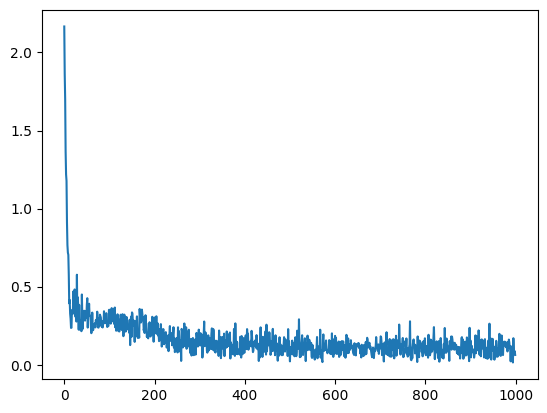

In [910]:
# plot the loss
plt.plot(losses)

In [911]:
gflownet.eval() 
samples = list() 
rewards = list() 
for _ in trange(int(3000)): 
    # Sample from the learned distribution 
    env = Graph(max_edges, num_nodes, batch_size) 
    env = gflownet.sample(env)
    samples.append(env.S) 
    rewards.append(log_reward(env)) 

samples = torch.cat(samples).cpu()  # Use torch.cat instead of torch.vstack
rewards = torch.cat(rewards).cpu()  # Use torch.cat instead of torch.hstack
samples.shape

100%|██████████| 3000/3000 [00:37<00:00, 79.19it/s]


torch.Size([384000, 5, 5])

Text(0, 0.5, 'Frequência nas amostras')

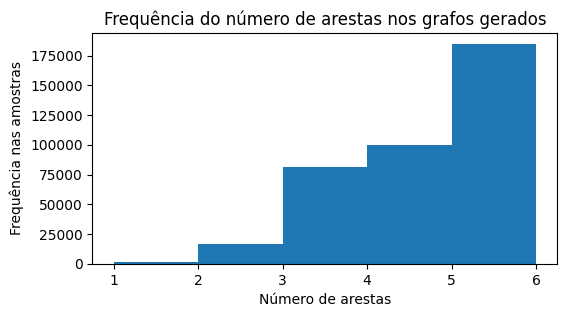

In [912]:
samples_int = samples.int()
samples_np = samples_int.numpy()
plt.figure(figsize=(6, 3))
plt.hist(samples_np.sum(axis=(1, 2)) / 2, bins=range(1, max_edges + 2))
plt.title('Frequência do número de arestas nos grafos gerados')
plt.xlabel('Número de arestas')   
plt.ylabel('Frequência nas amostras')

In [938]:
# count how many different matrices we have in samples_np that sum to 5 edges
samples_np_5_edges = samples_np[samples_np.sum(axis=(1, 2)) / 2 == 5]
# count unique graphs
unique_graphs = np.unique(samples_np_5_edges, axis=0)
print('Number of unique graphs with 5 edges:', unique_graphs.shape[0])
print('Number of graphs with 5 edges:', samples_np_5_edges.shape[0])

print('Mean number of occurrences of each unique graph:', samples_np_5_edges.shape[0] / unique_graphs.shape[0])

Number of unique graphs with 5 edges: 252
Number of graphs with 5 edges: 185058
Mean number of occurrences of each unique graph: 734.3571428571429


In [939]:
count5 = []
for graph in unique_graphs:
    # count how many times this graph appears in the samples_np_5_edges
    count5.append((samples_np_5_edges == graph).all(axis=(1, 2)).sum())
count5 = np.array(count5)
count5

array([771, 726, 739, 741, 717, 681, 736, 749, 754, 750, 744, 749, 725,
       700, 730, 747, 817, 790, 720, 748, 770, 683, 707, 669, 719, 696,
       749, 693, 703, 689, 717, 752, 764, 680, 712, 735, 681, 720, 723,
       734, 746, 779, 748, 724, 763, 761, 680, 737, 698, 696, 653, 675,
       747, 761, 781, 674, 738, 665, 726, 738, 694, 735, 654, 685, 670,
       734, 787, 726, 768, 675, 724, 750, 685, 755, 706, 774, 806, 748,
       769, 757, 744, 760, 804, 721, 769, 768, 698, 773, 742, 820, 793,
       717, 657, 685, 686, 714, 780, 756, 761, 714, 745, 693, 706, 675,
       655, 673, 681, 749, 757, 721, 710, 740, 726, 750, 708, 727, 706,
       752, 698, 804, 780, 735, 706, 772, 754, 805, 694, 721, 701, 715,
       749, 752, 762, 735, 688, 700, 778, 736, 703, 715, 716, 740, 721,
       750, 781, 796, 807, 743, 788, 778, 835, 744, 747, 740, 734, 721,
       742, 751, 780, 814, 796, 654, 692, 667, 684, 738, 687, 739, 726,
       712, 694, 716, 722, 672, 698, 696, 719, 757, 750, 730, 73

In [940]:
# count how many different matrices we have in samples_np that sum to 4 edges
samples_np_4_edges = samples_np[samples_np.sum(axis=(1, 2)) / 2 == 4]
# count unique graphs
unique_graphs = np.unique(samples_np_4_edges, axis=0)
print('Number of unique graphs with 4 edges:', unique_graphs.shape[0])
print('Number of graphs with 4 edges:', samples_np_4_edges.shape[0])

print('Mean number of occurrences of each unique graph:', samples_np_4_edges.shape[0] / unique_graphs.shape[0])

Number of unique graphs with 4 edges: 210
Number of graphs with 4 edges: 100268
Mean number of occurrences of each unique graph: 477.46666666666664


In [941]:
count4 = []
for graph in unique_graphs:
    # count how many times this graph appears in the samples_np_5_edges
    count4.append((samples_np_4_edges == graph).all(axis=(1, 2)).sum())
count4 = np.array(count4)
count4

array([433, 455, 451, 465, 453, 469, 448, 449, 438, 490, 518, 450, 463,
       439, 468, 530, 490, 497, 466, 523, 551, 486, 481, 519, 462, 488,
       527, 447, 491, 470, 511, 516, 550, 556, 507, 442, 425, 446, 449,
       467, 477, 440, 473, 430, 479, 389, 469, 442, 427, 413, 474, 457,
       448, 480, 442, 431, 482, 454, 444, 465, 470, 522, 484, 528, 491,
       523, 486, 497, 474, 466, 452, 491, 471, 448, 499, 454, 495, 495,
       467, 485, 478, 466, 462, 457, 444, 441, 523, 489, 459, 466, 486,
       531, 525, 453, 485, 486, 539, 539, 474, 501, 524, 464, 516, 534,
       551, 449, 426, 445, 476, 411, 445, 474, 424, 484, 488, 468, 448,
       438, 405, 507, 461, 494, 471, 470, 513, 452, 462, 459, 446, 440,
       467, 514, 494, 483, 476, 471, 482, 504, 450, 475, 444, 418, 531,
       502, 496, 500, 502, 530, 486, 470, 473, 468, 559, 497, 578, 491,
       495, 501, 466, 466, 526, 417, 419, 439, 449, 447, 408, 484, 459,
       473, 511, 466, 466, 452, 443, 465, 469, 453, 504, 513, 51

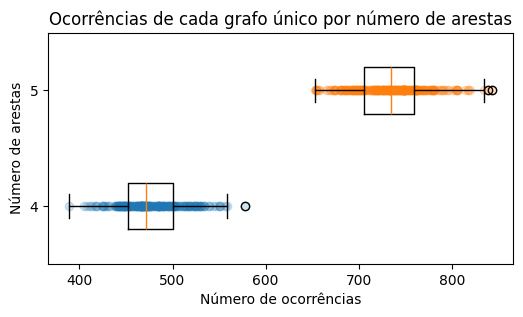

In [965]:
# disperse the points a little bit 
plt.figure(figsize=(6, 3))
plt.boxplot([count4, count5], labels=['4', '5'], vert=False, widths=0.4)
plt.scatter(count4, np.ones_like(count4) * 1, alpha=0.2)
plt.scatter(count5, np.ones_like(count5) * 2, alpha=0.2)
plt.title('Ocorrências de cada grafo único por número de arestas')
plt.xlabel('Número de ocorrências')
plt.ylabel('Número de arestas')
plt.show()

In [921]:
# samples_np = samples_int.numpy()
samples_np = samples_int.numpy()

# count number of edges in samples_np[0]
print(np.sum(samples_np[3]) / 2)
print(np.sum(samples_np[7]) / 2)

5.0
4.0


In [925]:
np.sum(np.all(samples_np == samples_np[3], axis=(1, 2)))

654

In [927]:
# check how many samples in samples_np are exaclty the same as samples_np[0]
n_samples_1 = np.sum(np.all(samples_np == samples_np[0], axis=(1, 2)))
n_samples_2 = np.sum(np.all(samples_np == samples_np[7], axis=(1, 2)))